# Flight Delay Predictions

# Weather Impact on Flight Delay

In this notebook, I analyzed the weather data provided by [National Oceanic and Atmospheric Administration](https://www.ncdc.noaa.gov/cdo-web/datasets). This dataset includes information about location, temperature, humidity, wind speeds, precipitation, weather events, etc. In this notebook I analyzed the corrolation between different weather elements such as temperature, humidity, dew point, wind speeds and precipitation on the flight delay.

### Data Import, Manipulation, and Exploration

In [1]:
#Import of basic libraries for data manipulation and plotting
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from datetime import datetime, date
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [2]:
# Training files are divided into three separate files in six month increments
temp_train_2014_1 = pd.read_csv('CAX_Train_2014_Jan_to_Jun.csv')
temp_train_2014_2 = pd.read_csv('CAX_Train_2014_Jul_to_Dec.csv')
temp_train_2015 = pd.read_csv('CAX_Train_2015.csv')

# Read in the weather file
weather = pd.read_csv('weather.csv')

# The codes file is a manual matching I created between the IATA codes in the 
# training files and the ICAO codes in the weather file. Multiple IATA codes can 
# join to the same ICAO codes based on proximity to cities. City names in the 
# training files can be truncated and often did not match the weather file. 
# If the matching wasn't obvious based on the IATA and ICAO codes then IATA 
# code were looked up in Google to determine thenearest ICAO city.
codes = pd.read_csv('training_weather_cities_joined.csv')

In [3]:
# Combine all of the training files into one dataframe
training = pd.concat([temp_train_2014_1, temp_train_2014_2, temp_train_2015], ignore_index=True)

#### Additional time features are added in order to identify possible trends 

In [5]:
# Create day of year, week of year, and hour features from the flight date
training['DAY_OF_YEAR'] = pd.to_datetime(training['FL_DATE'], 
                                         errors='coerce').dt.dayofyear.astype(int)
training['WEEK_OF_YEAR'] = pd.to_datetime(training['FL_DATE'], 
                                          errors='coerce').dt.weekofyear.astype(int)
training['hour'] = training['CRS_DEP_TIME'].map(lambda x: int(str(int(x)).zfill(4)[:2]))

In [6]:
# This array defines the dates of holidays in 2014 and 2015 which were looked up on the internet
holidays = [
        date(2014, 1, 1), date(2014, 1, 20), date(2014, 5, 26), date(2014, 7, 4),
        date(2014, 9, 1), date(2014, 11, 27), date(2014, 12, 25),
        date(2015, 1, 1), date(2015, 1, 19), date(2015, 5, 25), date(2015, 7, 4),
        date(2015, 9, 7), date(2015, 11, 26), date(2015, 12, 25)
     ]

#Function that gives the number of days from a date to the nearest holiday
def days_from_nearest_holiday(year, month, day):
  d = date(year, month, day)
  x = [(abs(d-h)).days for h in holidays]
  return min(x)

# Create the days from holiday feature using the defined function
training['days_from_holidays'] = [days_from_nearest_holiday(r.YEAR, r.MONTH, r.DAY_OF_MONTH) \
                                  for i,r in training.iterrows()]

## Weather features

Weather data is cleaned and manipulated below. It is then grouped by week of year and joined to the flight performance dataframe for both origin and destination airports.

In [14]:
# Creating week of year field in order to group weather events by week
# weather['week_of_year'] = pd.to_datetime(weather['date'], errors='coerce').dt.weekofyear.astype(
#     int)

# Some basic munging of weather fields
weather.events.fillna(-1, inplace=True)
weather.conditions.fillna(-1, inplace=True)
weather.gust_speed_mph.replace('-', -1, inplace=True)
weather.gust_speed_mph.fillna(-1, inplace=True)
weather.gust_speed_mph = pd.to_numeric(weather.gust_speed_mph, errors='coerce')
weather.wind_speed_mph.replace('Calm', 0, inplace=True)
weather.wind_speed_mph.fillna(-1, inplace=True)
weather.wind_speed_mph = pd.to_numeric(weather.wind_speed_mph, errors='coerce')

# Changing to weather types in the events field to numeric values based on the likelihood 
# of causing delays (e.g. Events involving ice have a higher values)
weather.events.replace(['Fog', 'Fog-Hail-Thunderstorm', 'Fog-Rain', 'Fog-Rain-Hail-Thunderstorm', 
                        'Fog-Rain-Snow', 'Fog-Rain-Thunderstorm', 
                        'Fog-Rain-Thunderstorm-Tornado', 'Fog-Snow', 'Fog-Snow-Thunderstorm', 
                        'Fog-Thunderstorm', 'Hail', 'Hail-Thunderstorm', 'Rain', 'Rain-Hail', 
                        'Rain-Hail-Thunderstorm', 'Rain-Snow', 'Rain-Snow-Thunderstorm', 
                        'Rain-Thunderstorm', 'Rain-Thunderstorm-Tornado', 'Rain-Tornado', 
                        'Snow', 'Snow-Hail', 'Snow-Thunderstorm', 'Snow-Tornado', 'Thunderstorm', 
                        'Thunderstorm-Tornado', 'Tornado'], [10, 80, 20, 80, 60, 50, 100, 60, 
                         60, 50, 80, 80, 20, 80, 80, 60, 60, 50, 100, 100, 60, 80, 60, 100, 
                         50, 100, 100], inplace=True)

# As with the events field, changing the conditions field to numeric values based on the 
# likelihood of causing delays
weather.conditions.replace(['Unknown', 'Clear', 'Overcast', 'Partly Cloudy', 'Drizzle', 
                            'Scattered Clouds', 'Mostly Cloudy', 'Haze', 'Mist', 
                            'Patches of Fog', 'Rain', 'Shallow Fog', 'Low Drifting Snow', 
                            'Rain Showers', 'Light Blowing Snow', 'Light Drizzle', 'Light Fog', 
                            'Light Hail', 'Light Ice Pellets', 'Light Low Drifting Snow', 
                            'Light Mist', 'Light Rain', 'Light Rain Showers', 'Light Sand', 
                            'Light Small Hail Showers', 'Light Smoke', 'Light Snow', 
                            'Light Snow Grains', 'Light Snow Showers', 'Light Thunderstorm', 
                            'Light Thunderstorms and Rain', 'Light Thunderstorms and Snow', 
                            'Light Thunderstorms with Hail', 
                            'Light Thunderstorms with Small Hail', 'Heavy Blowing Snow', 
                            'Heavy Drizzle', 'Heavy Freezing Drizzle', 'Heavy Freezing Fog', 
                            'Heavy Freezing Rain', 'Heavy Ice Pellets', 'Heavy Rain', 
                            'Heavy Rain Showers', 'Heavy Small Hail', 'Heavy Snow', 
                            'Heavy Snow Showers', 'Heavy Thunderstorm', 
                            'Heavy Thunderstorms and Rain', 'Heavy Thunderstorms and Snow', 
                            'Heavy Thunderstorms with Hail', 
                            'Heavy Thunderstorms with Small Hail', 'Ice Crystals', 
                            'Ice Pellets', 'Funnel Cloud', 'Blowing Sand', 'Blowing Snow', 
                            'Thunderstorm', 'Thunderstorms and Rain', 'Thunderstorms and Snow', 
                            'Thunderstorms with Hail', 'Thunderstorms with Small Hail', 
                            'Volcanic Ash', 'Widespread Dust', 'Sand', 'Sandstorm', 
                            'Small Hail', 'Small Hail Showers', 'Smoke', 'Snow', 'Snow Grains', 
                            'Snow Showers', 'Squalls', 'Fog', 'Freezing Rain', 'Hail', 
                            'Light Freezing Drizzle', 'Light Freezing Fog', 
                            'Light Freezing Rain'], [-1, 0, 0, 0, 10, 0, 0, 0, 0, 10, 10, 
                             10, 30, 10, 30, 10, 10, 50, 70, 30, 0, 10, 10, 30, 50, 20, 30, 
                             70, 30, 20, 20, 40, 60, 60, 80, 20, 70, 70, 90, 80, 20, 20, 70, 
                             80, 80, 50, 30, 80, 80, 80, 70, 70, 90, 70, 70, 40, 30, 70, 80, 
                             80, 100, 20, 60, 80, 60, 70, 20, 60, 60, 60, 70, 10, 80, 50, 60, 
                             50, 80], inplace=True)

In [15]:
# Grouping the weather features by week of year and airport
weather_group = weather.groupby( [ 'airport_code', 'date'] ).mean()
weather_group = weather_group.reset_index()
weather_group = weather_group.drop(['zip'], 1)
weather_group.fillna(-100, inplace=True)

In [16]:
# Merge the codes file to get the IACO codes for the origin IATA code
training = pd.merge(training, codes[['ORIGIN', 'city', 'airport_code']], 
                    left_on='ORIGIN', right_on='ORIGIN')
training.rename(columns={'city': 'origin_city', 'airport_code': 'origin_icao_code'}, inplace=True)

# Merge the codes file to get the IACO codes for the destination IATA code
training = pd.merge(training, codes[['ORIGIN', 'city', 'airport_code']], 
                    left_on='DEST', right_on='ORIGIN')
training.rename(columns={'city': 'dest_city', 'airport_code': 'dest_icao_code', 
                         'ORIGIN_x': 'ORIGIN'}, inplace=True)
training = training.drop('ORIGIN_y', 1)

# Merge the weather data with the training data on the origin and week of year
training = pd.merge(training, weather_group, left_on=['origin_icao_code', 'FL_DATE'], 
                    right_on=['airport_code', 'date'], how='left')
training.rename(columns={'conditions': 'orig_conditions', 'airport_code': 'orig_airport_code', 
                         'week_of_year': 'orig_week_of_year', 
                         'temperature_f': 'orig_temperature_f', 
                         'dew_point_f': 'orig_dew_point_f', 'humidity': 'orig_humidity', 
                         'sea_level_pressure_in': 'orig_sea_level_pressure_in', 
                         'visibility_mph': 'orig_visibility_mph', 
                         'wind_speed_mph': 'orig_wind_speed_mph', 
                         'gust_speed_mph': 'orig_gust_speed_mph', 
                         'precipitation_in': 'orig_precipitation_in', 
                         'events': 'orig_events', 'wind_dir_degrees': 'orig_wind_dir_degrees'\
                        }, inplace=True)

training = training.drop('date', 1)

# Merge the weather data with the training data on the destination and week of year
training = pd.merge(training, weather_group, left_on=['dest_icao_code', 'FL_DATE'], 
                    right_on=['airport_code', 'date'], how='left')
training.rename(columns={'conditions': 'dest_conditions', 'airport_code': 'dest_airport_code', 
                         'week_of_year': 'dest_week_of_year', 
                         'temperature_f': 'dest_temperature_f', 
                         'dew_point_f': 'dest_dew_point_f', 'humidity': 'dest_humidity', 
                         'sea_level_pressure_in': 'dest_sea_level_pressure_in', 
                         'visibility_mph': 'dest_visibility_mph', 
                         'wind_speed_mph': 'dest_wind_speed_mph', 
                         'gust_speed_mph': 'dest_gust_speed_mph', 
                         'precipitation_in': 'dest_precipitation_in', 
                         'events': 'dest_events', 'wind_dir_degrees': 'dest_wind_dir_degrees'\
                        }, inplace=True)

training = training.drop('date', 1)

training.fillna(-1, inplace=True)

#### Below are some charts exploring the impact of some weather features.

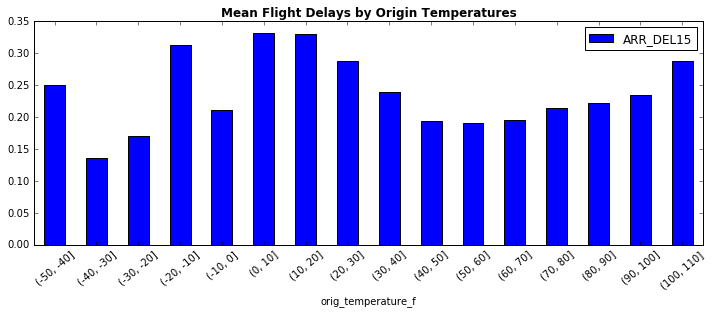

In [17]:
grouped = training[['ARR_DEL15']].groupby(pd.cut(training.orig_temperature_f, \
                                     np.arange(-50, 120, 10))).mean()

grouped.plot(kind='bar')
plt.xticks(rotation=40)
plt.title('Mean Flight Delays by Origin Temperatures', fontweight="bold")
plt.savefig('charts/delays_by_temps.png')

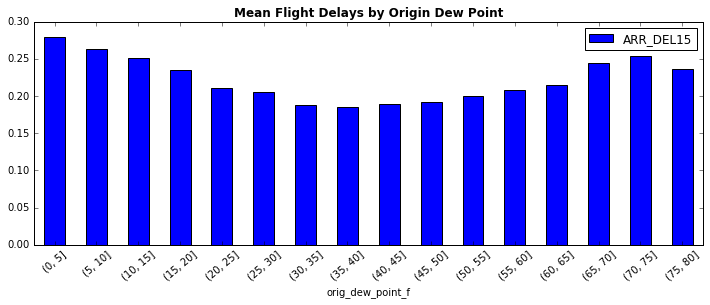

In [18]:
#Grouping gust speed into bins and getting the mean delay
grouped = training[['ARR_DEL15']].groupby(pd.cut(training.orig_dew_point_f, \
                                     np.arange(0, 85, 5))).mean()

grouped.plot(kind='bar')
plt.xticks(rotation=40)
plt.title('Mean Flight Delays by Origin Dew Point', fontweight="bold")
plt.savefig('charts/delays_by_dew_point.png')

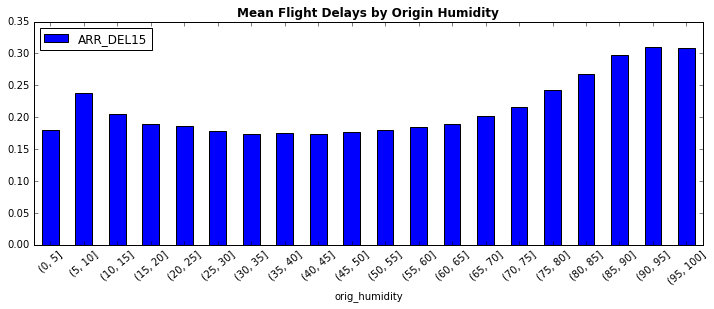

In [19]:
#Grouping gust speed into bins and getting the mean delay
grouped = training[['ARR_DEL15']].groupby(pd.cut(training.orig_humidity, \
                                     np.arange(0, 105, 5))).mean()

grouped.plot(kind='bar')
plt.xticks(rotation=40)
plt.title('Mean Flight Delays by Origin Humidity', fontweight="bold")
plt.savefig('charts/delays_by_humidity.png')

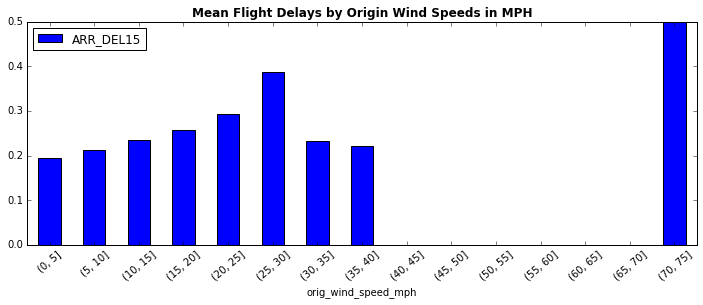

In [20]:
#Grouping wind speed into bins and getting the mean delay
grouped = training[['ARR_DEL15']].groupby(pd.cut(training.orig_wind_speed_mph, \
                                     np.arange(0, 80, 5))).mean()

grouped.plot(kind='bar')
plt.xticks(rotation=40)
plt.title('Mean Flight Delays by Origin Wind Speeds in MPH', fontweight="bold")
plt.savefig('charts/delays_by_wind_speed.png')

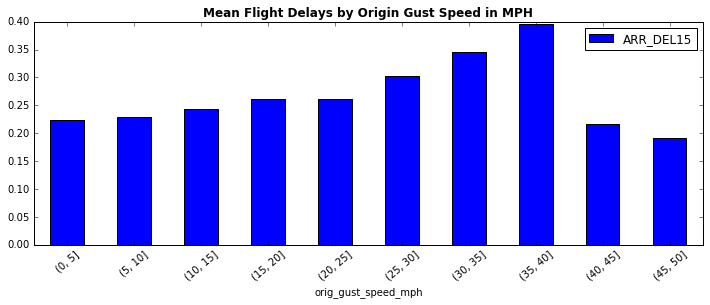

In [21]:
#Grouping gust speed into bins and getting the mean delay
grouped = training[['ARR_DEL15']].groupby(pd.cut(training.orig_gust_speed_mph, \
                                     np.arange(0, 55, 5))).mean()

grouped.plot(kind='bar')
plt.xticks(rotation=40)
plt.title('Mean Flight Delays by Origin Gust Speed in MPH', fontweight="bold")
plt.savefig('charts/delays_by_gust_speed.png')

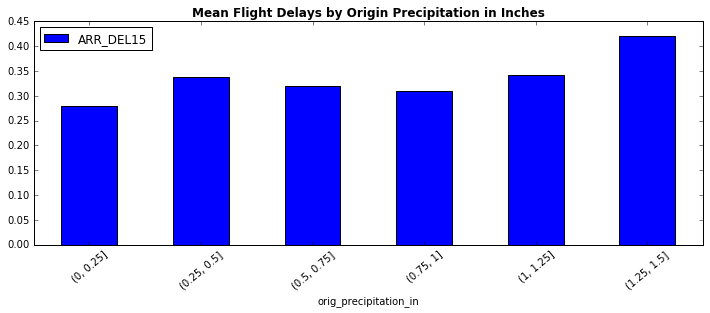

In [22]:
#Grouping inches of precipitation into bins and getting the mean delay
grouped = training[['ARR_DEL15']].groupby(pd.cut(training.orig_precipitation_in, \
                                     np.arange(0, 1.75, .25))).mean()

grouped.plot(kind='bar')
plt.xticks(rotation=40)
plt.title('Mean Flight Delays by Origin Precipitation in Inches', fontweight="bold")
plt.savefig('charts/delays_by_precipitation.png')

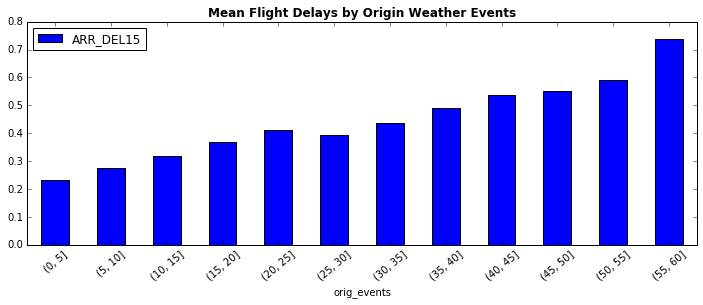

In [23]:
#Grouping wind degrees into bins and getting the mean delay
grouped = training[['ARR_DEL15']].groupby(pd.cut(training.orig_events, \
                                     np.arange(0, 65, 5))).mean()

grouped.plot(kind='bar')
plt.xticks(rotation=40)
plt.title('Mean Flight Delays by Origin Weather Events', fontweight="bold")
plt.savefig('charts/delays_by_weather_events.png')

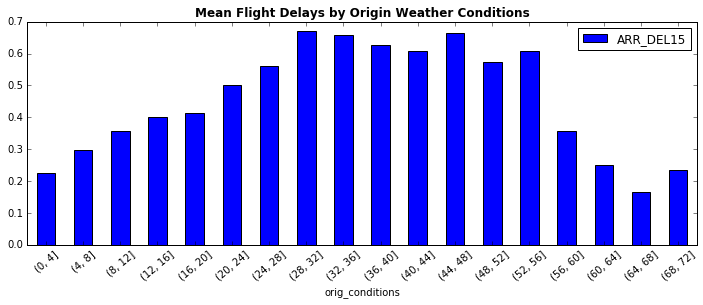

In [24]:
#Grouping wind degrees into bins and getting the mean delay
grouped = training[['ARR_DEL15']].groupby(pd.cut(training.orig_conditions, \
                                     np.arange(0, 76, 4))).mean()

grouped.plot(kind='bar')
plt.xticks(rotation=40)
plt.title('Mean Flight Delays by Origin Weather Conditions', fontweight="bold")
plt.savefig('charts/delays_by_weather_conditions.png')

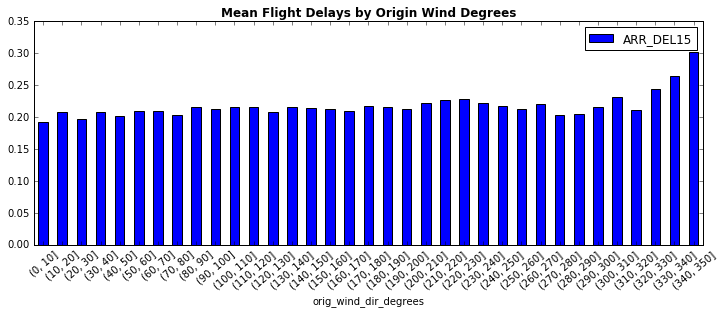

In [25]:
#Grouping wind degrees into bins and getting the mean delay
grouped = training[['ARR_DEL15']].groupby(pd.cut(training.orig_wind_dir_degrees, \
                                     np.arange(0, 360, 10))).mean()

grouped.plot(kind='bar')
plt.xticks(rotation=40)
plt.title('Mean Flight Delays by Origin Wind Degrees', fontweight="bold")

It appears that some weather events have an impact on flight delays.

The origin airports gust wind speeds appear to impact flights once it gets above 20 MPHs. Precipitation levels of around .7-.8 inches show increased flight delays. Temperatures between 5-25 degrees show increased impact on delays.

Both origin airport wind speeds and wind degrees do not appear to make a significant difference in flight delays.